In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.19.0


In [2]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: aml-poc-westus
Azure region: westus2
Subscription id: 1fb3620c-78c6-4fdc-b700-e4238cb192e6
Resource group: rg_aml_westus


In [93]:
from azureml.core import Datastore
datastore = Datastore.register_azure_blob_container(workspace = ws, 
                                        datastore_name = 'img_ds',
                                        container_name = 'source-data',
                                        account_name = 'amlpocwestus6466069240',
                                        sas_token = '?sv=2019-12-12&ss=b&srt=co&sp=rlx&se=2021-03-31T15:28:38Z&st=2021-02-02T07:28:38Z&spr=https&sig=3KyJdypHKf%2FxktopuYLAbzy6YszG3LTpMUKHD5Qkn3I%3D',
                                        overwrite=False
                                        )
print(datastore)

{
  "name": "img_ds",
  "container_name": "source-data",
  "account_name": "amlpocwestus6466069240",
  "protocol": "https",
  "endpoint": "core.windows.net"
}


In [94]:
from azureml.core import Dataset
datastore_paths = [(datastore, 'anji_data')]
dataset = Dataset.File.from_files(path=datastore_paths)

In [5]:
from azureml.core import Experiment

experiment_name = 'exp-yolov3-sample'
experiment = Experiment(ws, name=experiment_name)

In [95]:
from azureml.core import Environment

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', 
                                                file_path = './conda_dependencies.yml'
                                                )

In [104]:
from azureml.core import ScriptRunConfig

project_folder = '.'

src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=['--epochs', 6,'--data-folder', dataset.as_mount('/tmp/tmp_imgdata')],
                      environment=pytorch_env)

In [105]:
run = experiment.submit(src,tags={"purpose":"AML yolov3 sample"})
print(run)

Run(Experiment: exp-yolov3-sample,
Id: exp-yolov3-sample_1612253233_b037f529,
Type: azureml.scriptrun,
Status: Starting)


In [106]:
run.wait_for_completion(show_output=True)

RunId: exp-yolov3-sample_1612253233_b037f529
Web View: https://ml.azure.com/experiments/exp-yolov3-sample/runs/exp-yolov3-sample_1612253233_b037f529?wsid=/subscriptions/1fb3620c-78c6-4fdc-b700-e4238cb192e6/resourcegroups/rg_aml_westus/workspaces/aml-poc-westus

Streaming azureml-logs/70_driver_log.txt

[2021-02-02T08:07:27.518920] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'Dataset:context_managers.Datasets', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError', 'UserExceptions:context_managers.UserExceptions'], invocation=['train.py', '--epochs', '6', '--data-folder', 'DatasetConsumptionConfig:input__8dd69fbc'])
Initialize DatasetContextManager.
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 127422
Set Dataset input__8dd69fbc's target path to /tmp/tmp_imgdata
Enter __enter__ of 

{'runId': 'exp-yolov3-sample_1612253233_b037f529',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-02-02T08:07:27.321902Z',
 'endTimeUtc': '2021-02-02T08:32:31.145867Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': 'ab279497-1284-4923-8feb-de4ca79647cf'},
 'inputDatasets': [{'dataset': {'id': 'd8218672-84fd-4ffa-83a0-68bf2438d0e2'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__8dd69fbc', 'mechanism': 'Mount', 'pathOnCompute': '/tmp/tmp_imgdata'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--epochs',
   '6',
   '--data-folder',
   'DatasetConsumptionConfig:input__8dd69fbc'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {'input__8dd69fbc': {'dataLocation': {'dataset': {'id': 'd8218672-84fd-4ffa-83a0-68bf2438d0e2',
      'name': None,
     

In [37]:
assert(run.get_status() == "Completed")

In [102]:
print(run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/70_driver_log.txt', 'logs/azureml/118061_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_l_0379a60c-6ef2-477b-8c69-f2b9b549f71a.jsonl', 'logs/azureml/dataprep/engine_spans_l_801f3f36-0a26-4a02-994c-1a1eac4d3ded.jsonl', 'logs/azureml/dataprep/python_span_l_0379a60c-6ef2-477b-8c69-f2b9b549f71a.jsonl', 'logs/azureml/dataprep/python_span_l_801f3f36-0a26-4a02-994c-1a1eac4d3ded.jsonl', 'outputs/best.pt', 'outputs/last.pt']


In [107]:
# Register Model
model = run.register_model(model_name = 'yolov3-sample-model', model_path = 'outputs/best.pt')
print(model.name, model.id, model.version, sep = '\t')

yolov3-sample-model	yolov3-sample-model:4	4


In [108]:
# Deploy Model
from azureml.core import Environment
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

#model = Model(ws, 'yolov3-sample-model')

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './conda_dependencies.yml')
dockerfile = """
FROM mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04
RUN apt update
RUN apt-get -y install sudo
RUN sudo apt -y install libgl1-mesa-glx
"""
pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = None
pytorch_env.docker.base_dockerfile = dockerfile
pytorch_env.inferencing_stack_version = 'latest'

inference_config = InferenceConfig(
        entry_script="score.py", 
        environment=pytorch_env,
        source_directory = "./"
        )

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=2, 
                                               tags={'framework':'pytorch'},
                                               description='ACI with Yolov3')

service = Model.deploy(workspace=ws, 
                           name='aci-yolov3-sample', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running........................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [21]:
service.get_logs()

'2021-02-02T04:19:53,918067782+00:00 - iot-server/run \n2021-02-02T04:19:53,918278882+00:00 - rsyslog/run \n2021-02-02T04:19:53,918094982+00:00 - gunicorn/run \n2021-02-02T04:19:53,946329743+00:00 - nginx/run \nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2021-02-02T04:19:54,074605463+00:00 - iot-server/finish 1 0\n2021-02-02T04:19:54,076016961+00:00 - Exit code 1 is normal. Not restarting iot-server.\nStarting gunicorn 19.9.0\nListening at: http://127.0.0.1:31311 (13)\nUsing worker: sync\nworker timeout is set to 300\nBooting worker with pid: 41\nSPARK_HOME not set. Skipping PySpark Initialization.\nGenerating new fontManager, this may take some time...\nInitializing logger\n2021-02-02 04:19:56,986 | root | INFO | Starting up app insights client\n2021-02-02 04:19:56,986 | root | INFO | Starting up request id generator\n2021-02-02 04:19:56,986 | root | INFO | Starting up app insight hooks\n2021-02-02 04:19:56,986 | root | INFO | Invoking user\'s init func

In [22]:
print(service.scoring_uri)

http://58a1e7c5-8d31-4a6a-b01b-c5d8ca90aafe.westus2.azurecontainer.io/score


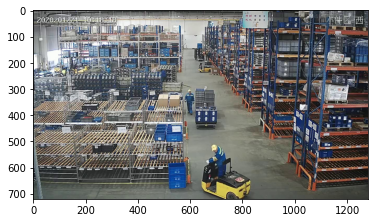

In [109]:
import json
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(Image.open('testfiles/test-image-2.jpg'))

In [110]:
import requests
from base64 import b64encode
# send a random row from the test set to score
with open('testfiles/test-image-2.jpg', 'rb') as jpg_file:
    byte_content = jpg_file.read()
    jpg_file.close()
base64_bytes = b64encode(byte_content)
base64_string = base64_bytes.decode()

input_data=json.dumps({'data': base64_string})

headers = {'Content-Type':'application/json'}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

max_len = len(resp.text) -1
result = resp.text[1:max_len].replace("\\","")

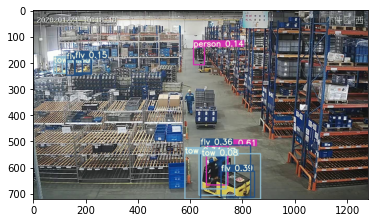

In [111]:
import base64

result_image = json.loads(result)["result_image"]

image_data = base64.b64decode(result_image)

with open('testfiles/test-impage-2-detection.jpg', 'wb') as jpg_file:
    jpg_file.write(image_data)

%matplotlib inline
plt.imshow(Image.open('testfiles/test-impage-2-detection.jpg'))

In [ ]:
# 删除ACI
service.delete()

In [92]:
# 删除data store
datastore.unregister()
